# Sample data for insurance portfolio optimisation

The problem of portfolio optimisation is to:

$$\min q \sum_i \sum_j x_i x_j \sigma_{ij} - \sum_i x_i \mu_i$$

$$s.t. \sum_i x_i = B$$

Here 

* $q>0$ is the risk appetite of the decision maker. 5% is a reasonable value for this case.
* $x_i$ is the decision variable indicating whether property i is included in the portfolio.
* $\sigma_{ij}$ represents the correlation between properties i and j.
* $\mu_i$ is the expected return on the property i, i.e., the premium, which we assume to be fixed (and given) in this case.
* B is the budget, i.e., how many properties a decision maker wants in its portfolio. 10% of the possible properties is a reasonable value for this case.

To create sample data, you could run the cell below.


In [260]:
from pennylane import numpy as np

np.random.seed(42)
n_properties = 10
budget = 3

# Step 1: Set a known optimal bitstring (with exactly `budget` ones)
X_opt = np.zeros(n_properties)
X_opt[[1, 4, 7]] = 1  # you choose these positions
X_opt = X_opt.astype(int)

# Step 2: Generate premiums (mu)
mu = np.random.uniform(0.05, 0.15, n_properties)

# Boost the premiums of the "true" optimal ones
mu[X_opt == 1] += 0.2  # make them significantly more attractive

# Step 3: Build a correlation matrix (sigma)
# Low correlation between selected properties
base_corr = np.random.uniform(0.1, 0.3, (n_properties, n_properties))
correlation_matrix = (base_corr + base_corr.T) / 2
np.fill_diagonal(correlation_matrix, 1)

# Now, add stronger correlation between non-optimal properties to make them riskier
for i in range(n_properties):
    for j in range(n_properties):
        if X_opt[i] == 0 and X_opt[j] == 0 and i != j:
            correlation_matrix[i, j] += 0.3  # make non-selected more correlated

# Step 4: Turn into covariance-like structure
sigma = correlation_matrix * np.outer(mu, mu)


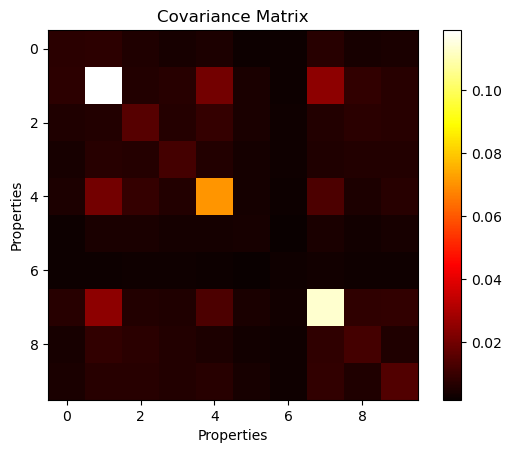

In [261]:
# plot sigma as image
import matplotlib.pyplot as plt

plt.imshow(sigma, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Covariance Matrix")
plt.xlabel("Properties")
plt.ylabel("Properties")
plt.show()

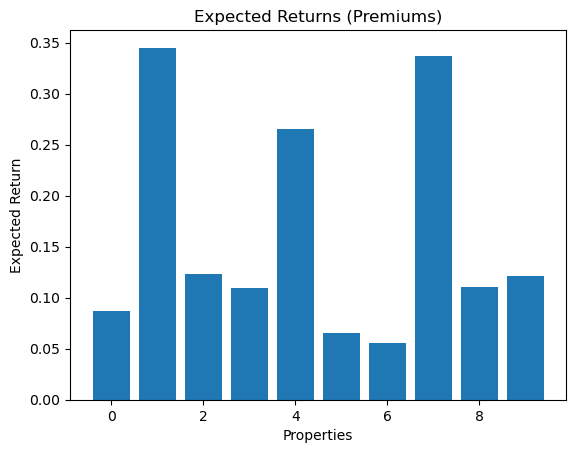

In [262]:
# Plot mu as bar chart
plt.bar(range(n_properties), mu)
plt.title("Expected Returns (Premiums)")
plt.xlabel("Properties")
plt.ylabel("Expected Return")
plt.show()

BUILD QUBO MATRIX

In [263]:
lambda_ = 0.1    # trade-off: reward return vs. minimize correlation
P = 10           # 10 is too low!
n = n_properties
k = budget

# Start with the covariance matrix as risk
Q = sigma.copy()

# Add premium (expected return) as a negative reward
for i in range(n):
    Q[i, i] -= lambda_ * mu[i]

# Add constraint penalty: (sum x_i - k)^2
for i in range(n):
    Q[i, i] += P * (1 - 2 * k)
    for j in range(n):
        if i != j:
            Q[i, j] += P


In [264]:
print(Q)

[[-50.0010972   10.00779121  10.0058612   10.00416456  10.00499728
   10.00262297  10.00247766  10.00702952  10.00438299  10.00456692]
 [ 10.00779121 -49.91543285  10.00621818  10.00705738  10.02044933
   10.00465525  10.002693    10.02482896  10.00876066  10.00701536]
 [ 10.0058612   10.00621818 -49.99714185  10.00674506  10.00950617
   10.00455583  10.00296346  10.00592444  10.00738653  10.00707632]
 [ 10.00416456  10.00705738  10.00674506 -49.99891608  10.00628435
   10.00361746  10.00314369  10.00585669  10.00617938  10.00622939]
 [ 10.00499728  10.02044933  10.00950617  10.00628435 -49.95601584
   10.00383803  10.00266121  10.01347321  10.00531161  10.00716461]
 [ 10.00262297  10.00465525  10.00455583  10.00361746  10.00383803
  -50.00225666  10.00178288  10.00469767  10.00329983  10.00414961]
 [ 10.00247766  10.002693    10.00296346  10.00314369  10.00266121
   10.00178288 -50.00246626  10.00338835  10.00299957  10.00305162]
 [ 10.00702952  10.02482896  10.00592444  10.00585669  

In [265]:
J = np.zeros((n, n))
h = np.zeros(n)

for i in range(n):
    h[i] = -0.5 * Q[i, i]
    for j in range(i + 1, n):
        J[i, j] = 0.25 * Q[i, j]
        h[i] += 0.25 * Q[i, j]
        h[j] += 0.25 * Q[i, j]


In [266]:
import pennylane as qml

coeffs = []
obs = []

for i in range(n):
    coeffs.append(h[i])
    obs.append(qml.PauliZ(i))

for i in range(n):
    for j in range(i + 1, n):
        if J[i, j] != 0:
            coeffs.append(J[i, j])
            obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

H = qml.Hamiltonian(coeffs, obs)
print(H)

47.511522178496925 * Z(0) + 44.97813596115309 * Z(1) + 42.509610374013256 * Z(2) + 40.00728578257892 * Z(3) + 37.48612008723991 * Z(4) + 35.00461082712811 * Z(5) + 32.50359301708726 * Z(6) + 29.96458495752572 * Z(7) + 27.50088549894804 * Z(8) + 24.998743166122868 * Z(9) + 2.5019478032234077 * (Z(0) @ Z(1)) + 2.501465298885547 * (Z(0) @ Z(2)) + 2.5010411401086428 * (Z(0) @ Z(3)) + 2.5012493207858797 * (Z(0) @ Z(4)) + 2.500655743431931 * (Z(0) @ Z(5)) + 2.500619415822895 * (Z(0) @ Z(6)) + 2.5017573789438603 * (Z(0) @ Z(7)) + 2.5010957480916702 * (Z(0) @ Z(8)) + 2.5011417307062214 * (Z(0) @ Z(9)) + 2.501554545989516 * (Z(1) @ Z(2)) + 2.501764346209176 * (Z(1) @ Z(3)) + 2.5051123335292043 * (Z(1) @ Z(4)) + 2.501163813033746 * (Z(1) @ Z(5)) + 2.5006732500991253 * (Z(1) @ Z(6)) + 2.506207240765507 * (Z(1) @ Z(7)) + 2.502190165030808 * (Z(1) @ Z(8)) + 2.5017538410862676 * (Z(1) @ Z(9)) + 2.501686265935559 * (Z(2) @ Z(3)) + 2.5023765415762727 * (Z(2) @ Z(4)) + 2.501138956708955 * (Z(2) @ Z(5))

In [267]:
dev = qml.device("default.qubit", wires=n)

@qml.qnode(dev)
def circuit(params):
    for i in range(n):
        qml.RY(params[i], wires=i)
    for i in range(n - 1):
        qml.CNOT(wires=[i, i + 1])
    return qml.expval(H)



(<Figure size 1300x1100 with 1 Axes>, <Axes: >)


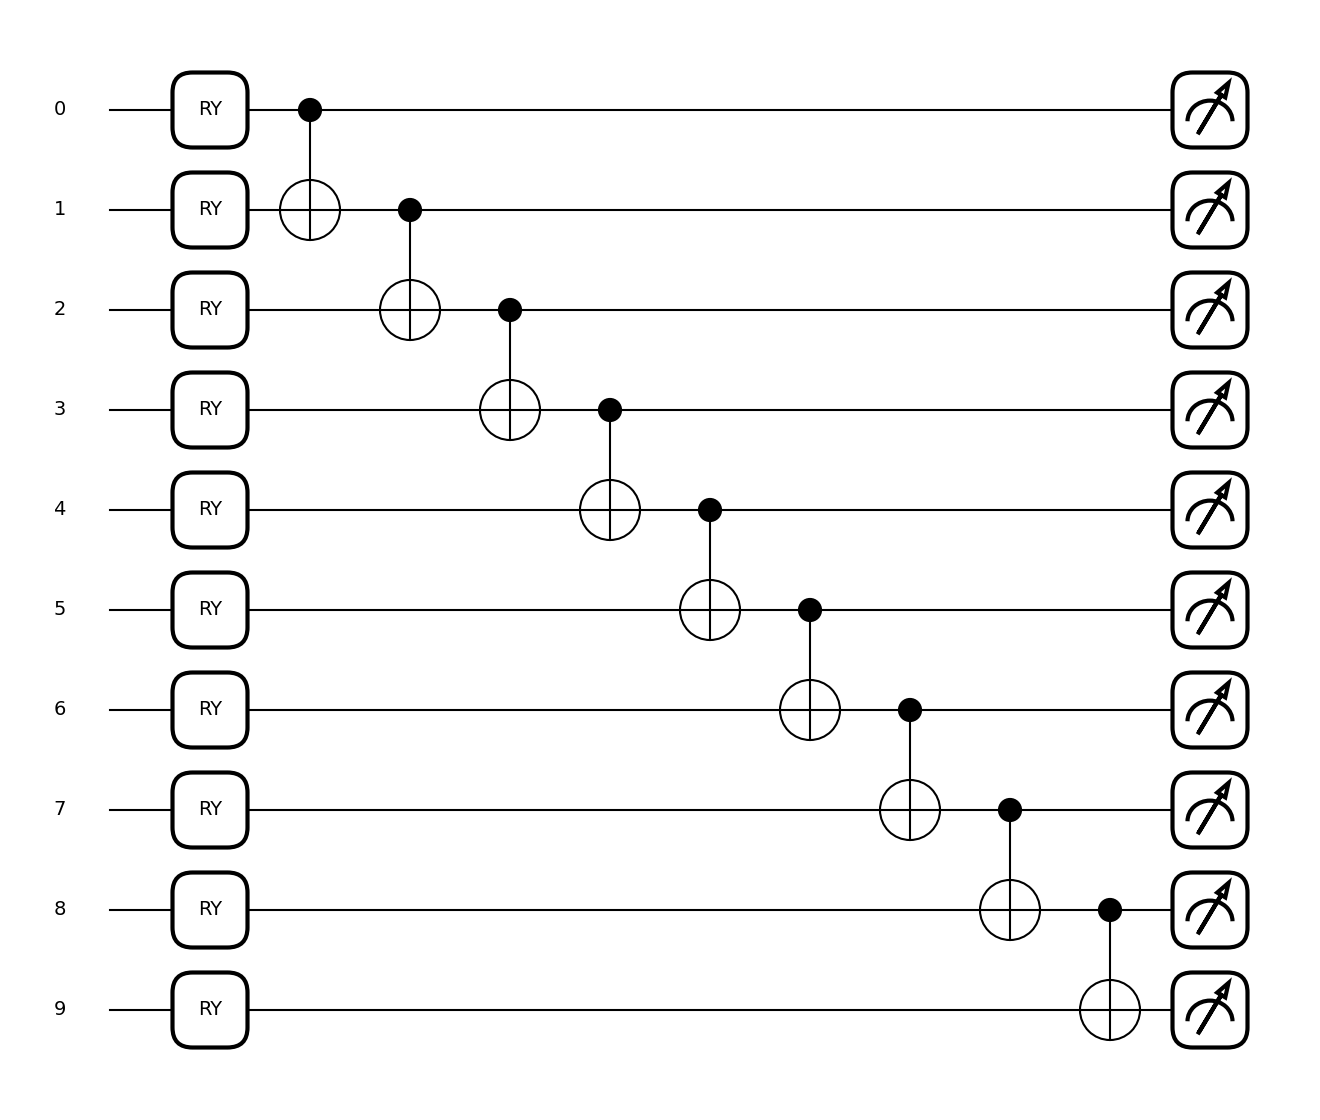

In [268]:
print(qml.draw_mpl(circuit, max_size=5)(np.zeros(n)))

In [269]:
def cost_fn(params):
    return circuit(params)  # this returns ⟨H⟩


In [270]:
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

# Create trainable parameters correctly
params = np.tensor(np.random.uniform(0, np.pi, size=n), requires_grad=True)

opt = AdamOptimizer(stepsize=0.1)
steps = 100

for i in range(steps):
    params = opt.step(cost_fn, params)
    if i % 10 == 0:
        energy = cost_fn(params)
        print(f"Step {i:3d} | Cost (Energy): {energy:.6f}")


Step   0 | Cost (Energy): -28.873481
Step  10 | Cost (Energy): -137.677285
Step  20 | Cost (Energy): -158.457145
Step  30 | Cost (Energy): -178.039769
Step  40 | Cost (Energy): -188.115002
Step  50 | Cost (Energy): -190.666708
Step  60 | Cost (Energy): -195.275518
Step  70 | Cost (Energy): -203.474639
Step  80 | Cost (Energy): -204.686668
Step  90 | Cost (Energy): -204.529393


In [271]:
print(params)

[ 3.14382285e+00  3.14327544e+00  3.14543438e+00 -2.27995507e-03
  4.18066214e-04  4.71587002e-03  2.70173554e-03  3.20168961e-03
  3.13798849e-02  5.11322629e-02]


Let's sample now to find the optimal bitstring

In [272]:
dev = qml.device("default.qubit", wires=n, shots=1000)  # 👈 Add shots here

@qml.qnode(dev)
def sampling_circuit(params):
    for i in range(n):
        qml.RY(params[i], wires=i)
    for i in range(n - 1):
        qml.CNOT(wires=[i, i + 1])
    return qml.sample(wires=range(n))


In [273]:
samples = sampling_circuit(params)  # shape = (shots, n)
from collections import Counter

bitstrings = ["".join(str(b) for b in sample) for sample in samples]
counts = Counter(bitstrings)

# Print the most frequent samples
for bitstring, count in counts.most_common(5):
    print(f"{bitstring} -> {count} times")


1011111111 -> 999 times
1011111100 -> 1 times


In [ ]:
def evaluate_energy(x):
    z = 1 - 2 * np.array(x)  # convert 0/1 → ±1
    energy = sum(h[i] * z[i] for i in range(n))
    energy += sum(J[i, j] * z[i] * z[j] for i in range(n) for j in range(i+1, n))
    return energy

# Get all sample energies
sample_energies = [(sample, evaluate_energy(sample)) for sample in samples]
best_sample = min(sample_energies, key=lambda x: x[1])[0]



In [275]:
print(evaluate_energy([0,1,0,0,1,0,0,1,0,0]))

145.11323161775022


In [280]:
print(evaluate_energy(best_sample))

-160.01606119313806


In [277]:
print("Best decision vector X:", best_sample)


Best decision vector X: [1 0 1 1 1 1 1 1 0 0]
